Import statements

In [3]:
import numpy as np
import pandas as pd
import re
import os
import glob
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors

Load the Data adequately

In [4]:
# the name of our directory
dname = os.path.dirname(os.getcwd()) + "/data_loading/data_v2_quotes/"
dname

'c:\\Users\\Jirko\\Desktop\\Hip_Lab\\analysis_scripts/data_loading/data_v2_quotes/'

In [5]:
# load the data
df = pd.read_csv(dname + "full_data.csv")
# drop redundant columns
df.drop(columns=["trial_bonus", "block_bonus", "resp_indices", "resp_indices_values", "resp_timestamp", "resp_reactiontime"], inplace=True)
df.head(3)

,Unnamed: 0,id,expt_index,expt_trial,expt_block,trial_att,vbxi_category,exemplar,trialProperties,trialPropShuff,property_order,resp_correct_array,resp_correct_array_unshuf,prop_responses,groundTruthCorrect,groundTruthCorrect_unshuf
0,0,0,0,0,0,1,7,10,"[1, 0, 1, 0, 0, 0, 1]","[[0, 1, 0, 0, 1, 0, 1], [0, 0, 0, 1, 1, 1, 0]]","[[1, 0, 5, 4, 2, 3, 6], [5, 3, 4, 2, 0, 6, 1]]","[[False, True, False, None, None, None, None],...","[[True, False, None, None, None, False, None],...","[[1, 1, 1, None, None, None, None], [None, Non...","[[0, 1, 0, 1, 0, 1, 0], [1, 1, 1, 1, 1, 1, 1]]","[[1, 0, 0, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1]]"
1,1,0,1,1,0,0,7,0,"[1, 0, 1, 0, 0, 0, 1]","[[1, 1, 1, 0, 0, 0, 0]]","[[0, 6, 2, 3, 1, 5, 4]]","[[True, True, True, None, None, None, None]]","[[True, None, True, None, None, None, True]]","[[1, 1, 1, None, None, None, None]]","[[1, 1, 1, 1, 1, 1, 1]]","[[1, 1, 1, 1, 1, 1, 1]]"
2,2,0,2,2,0,1,3,1,"[1, 1, 0, 0, 1, 0, 0]","[[1, 0, 0, 0, 1, 0, 1], [1, 1, 1, 0, 0, 0, 0]]","[[4, 2, 5, 3, 1, 6, 0], [0, 4, 1, 2, 5, 3, 6]]","[[None, None, False, False, True, None, None],...","[[None, True, None, False, None, False, None],...","[[None, None, 1, 1, 1, None, None], [1, 1, 1, ...","[[0, 1, 0, 0, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1]]","[[0, 1, 1, 0, 0, 0, 1], [1, 1, 1, 1, 1, 1, 1]]"


In [6]:
# find the subjects
sujs = df['id'].unique()
# select all rows from first block
df_block0 = df.loc[df['expt_block'] == 0] # df.loc[:, df.loc['expt_block'] == 0]
df_block0.shape
# select all rows for our first category
df_block0_cat01 = df_block0.loc[df_block0['vbxi_category'].isin([0, 1])]
df_block0_cat01.head(3)

,Unnamed: 0,id,expt_index,expt_trial,expt_block,trial_att,vbxi_category,exemplar,trialProperties,trialPropShuff,property_order,resp_correct_array,resp_correct_array_unshuf,prop_responses,groundTruthCorrect,groundTruthCorrect_unshuf
3,3,0,3,3,0,1,1,1,"[1, 1, 0, 1, 0, 0, 0]","[[1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 1, 1, 0, 0]]","[[0, 1, 3, 4, 6, 5, 2], [6, 0, 4, 1, 3, 5, 2]]","[[None, None, True, False, None, False, None],...","[[None, None, None, True, False, False, None],...","[[None, None, 1, 1, None, 1, None], [None, 1, ...","[[0, 0, 1, 0, 1, 0, 1], [1, 1, 1, 1, 1, 1, 1]]","[[0, 0, 1, 1, 0, 0, 1], [1, 1, 1, 1, 1, 1, 1]]"
5,5,0,5,5,0,1,1,9,"[1, 1, 0, 1, 0, 0, 0]","[[0, 0, 1, 1, 0, 1, 0], [1, 1, 0, 0, 0, 1, 0]]","[[6, 4, 0, 1, 2, 3, 5], [0, 3, 5, 6, 2, 1, 4]]","[[None, None, True, None, False, True, None], ...","[[True, None, False, True, None, None, None], ...","[[None, None, 1, None, 1, 1, None], [1, 1, Non...","[[1, 1, 1, 0, 0, 1, 1], [1, 1, 1, 1, 1, 1, 1]]","[[1, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]"
7,7,0,7,7,0,3,0,2,"[1, 1, 0, 1, 0, 0, 0]","[[1, 0, 0, 1, 1, 0, 0], [1, 0, 0, 1, 0, 0, 1],...","[[1, 5, 2, 3, 0, 4, 6], [1, 4, 2, 0, 6, 5, 3],...","[[None, None, False, True, True, None, None], ...","[[True, None, False, True, None, None, None], ...","[[None, None, 1, 1, 1, None, None], [1, 1, Non...","[[0, 1, 0, 1, 1, 1, 1], [1, 0, 1, 1, 1, 1, 0],...","[[1, 0, 0, 1, 1, 1, 1], [1, 1, 1, 0, 0, 1, 1],..."


In [7]:
# get the average response vector in the first block for the first two categories
vec_bl0_cat01 = df_block0_cat01["resp_correct_array_unshuf"]
vec_bl0_cat01 = vec_bl0_cat01.apply(lambda x: np.asarray(literal_eval(x)[0]))
vec_bl0_cat01 = vec_bl0_cat01.apply(lambda x: np.select([x == True, x == False],[1, 1]))
vec_bl0_cat01 =  vec_bl0_cat01.sum(axis=0)/vec_bl0_cat01.shape[0]
print(vec_bl0_cat01)

[0.70754717 0.58490566 0.34433962 0.55188679 0.29716981 0.22641509
 0.28773585]


In [192]:
def input_output_matrix(df):
    """function to create the input output matrix"""
    
    # get lists of the blocks and categories
    blocks = df['expt_block'].unique()
    categs = (df['vbxi_category'].unique())
    categs.sort()

    # create a 3D tensor to store the category specific performance across blocks
    in_out_matrix = np.full((7, int(len(categs)/2), len(blocks)), np.nan)

    for block in blocks:

        # select block specific part of dataframe
        df_block = df.loc[df['expt_block'] == block]

        for i, categ in enumerate(categs[::2]):
            
            # slightly tedious selection of the relevant cateogries
            df_block_categ = df_block.loc[df_block['vbxi_category'].isin([categ, categ + 1])]
            df_block_categ = df_block_categ["resp_correct_array_unshuf"]

            # change the evaluation as pandas read my lists as strings
            df_block_categ = df_block_categ.apply(lambda x: np.asarray(literal_eval(x)[0]))

            # we change the coding of our data adequatly for storage
            df_block_categ = df_block_categ.apply(lambda x: np.select([x == True, x == False],[1, 1]))

            # get mean array of property responses for each block and category
            array_block_categ = df_block_categ.sum(axis=0)/df_block_categ.shape[0]
            # place the result in our output
            in_out_matrix[:, i, block] = array_block_categ
    
    return in_out_matrix

in_out_matrix = input_output_matrix(df)
# np.save(dname + 'in_out_matrix.npy', in_out_matrix)
print(in_out_matrix.shape)

(7, 4, 8)


A second Version of the Matrix with trial wise info

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]


In [208]:
def input_output_matrix_trialwise(df):
    """function to create the input output matrix"""
    
    # get lists of the blocks and categories
    blocks = df['expt_block'].unique()
    categs = df['vbxi_category'].unique()
    expt_index = df['expt_index'].unique()
    categs.sort()

    # create a 3D tensor to store the category specific performance across blocks
    in_out_matrix_trialwise = np.full((7, int(len(categs)/2), len(expt_index)), np.nan)

    for trial in expt_index:

        # select trial specific part of dataframe
        df_trial = df.loc[df['expt_index'] == trial]

        for i, categ in enumerate(categs[::2]):
            
            # slightly tedious selection of the relevant cateogries
            df_trial_categ = df_trial.loc[df_trial['vbxi_category'].isin([categ, categ + 1])]
            df_trial_categ = df_trial_categ["resp_correct_array_unshuf"]

            # change the evaluation as pandas read my lists as strings
            df_trial_categ = df_trial_categ.apply(lambda x: np.asarray(literal_eval(x)[0]))

            # we change the coding of our data adequatly for storage
            df_trial_categ = df_trial_categ.apply(lambda x: np.select([x == True, x == False],[1, 1]))

            # get mean array of property responses for each block and category
            
            array_trial_categ = df_trial_categ.sum(axis=0)/df_trial_categ.shape[0]
            
            # place the result in our output
            in_out_matrix_trialwise[:, i, trial] = array_trial_categ
    
    return in_out_matrix_trialwise

in_out_matrix_trialwise = input_output_matrix_trialwise(df)
print(in_out_matrix[:,:,0])
np.save(dname + 'in_out_matrix_trialwise.npy', in_out_matrix)
#print(in_out_matrix.shape)

[[0.70754717 0.62765957 0.70879121 0.6980198 ]
 [0.58490566 0.5106383  0.42857143 0.40594059]
 [0.34433962 0.41489362 0.52197802 0.49009901]
 [0.55188679 0.32978723 0.3021978  0.36633663]
 [0.29716981 0.49468085 0.29120879 0.32178218]
 [0.22641509 0.32446809 0.41758242 0.29207921]
 [0.28773585 0.29787234 0.32967033 0.42574257]]


Now we plot, first we define parameters

In [9]:
cmap = matplotlib.cm.get_cmap('Set1')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

Now we plot first the block wise input-output matrix

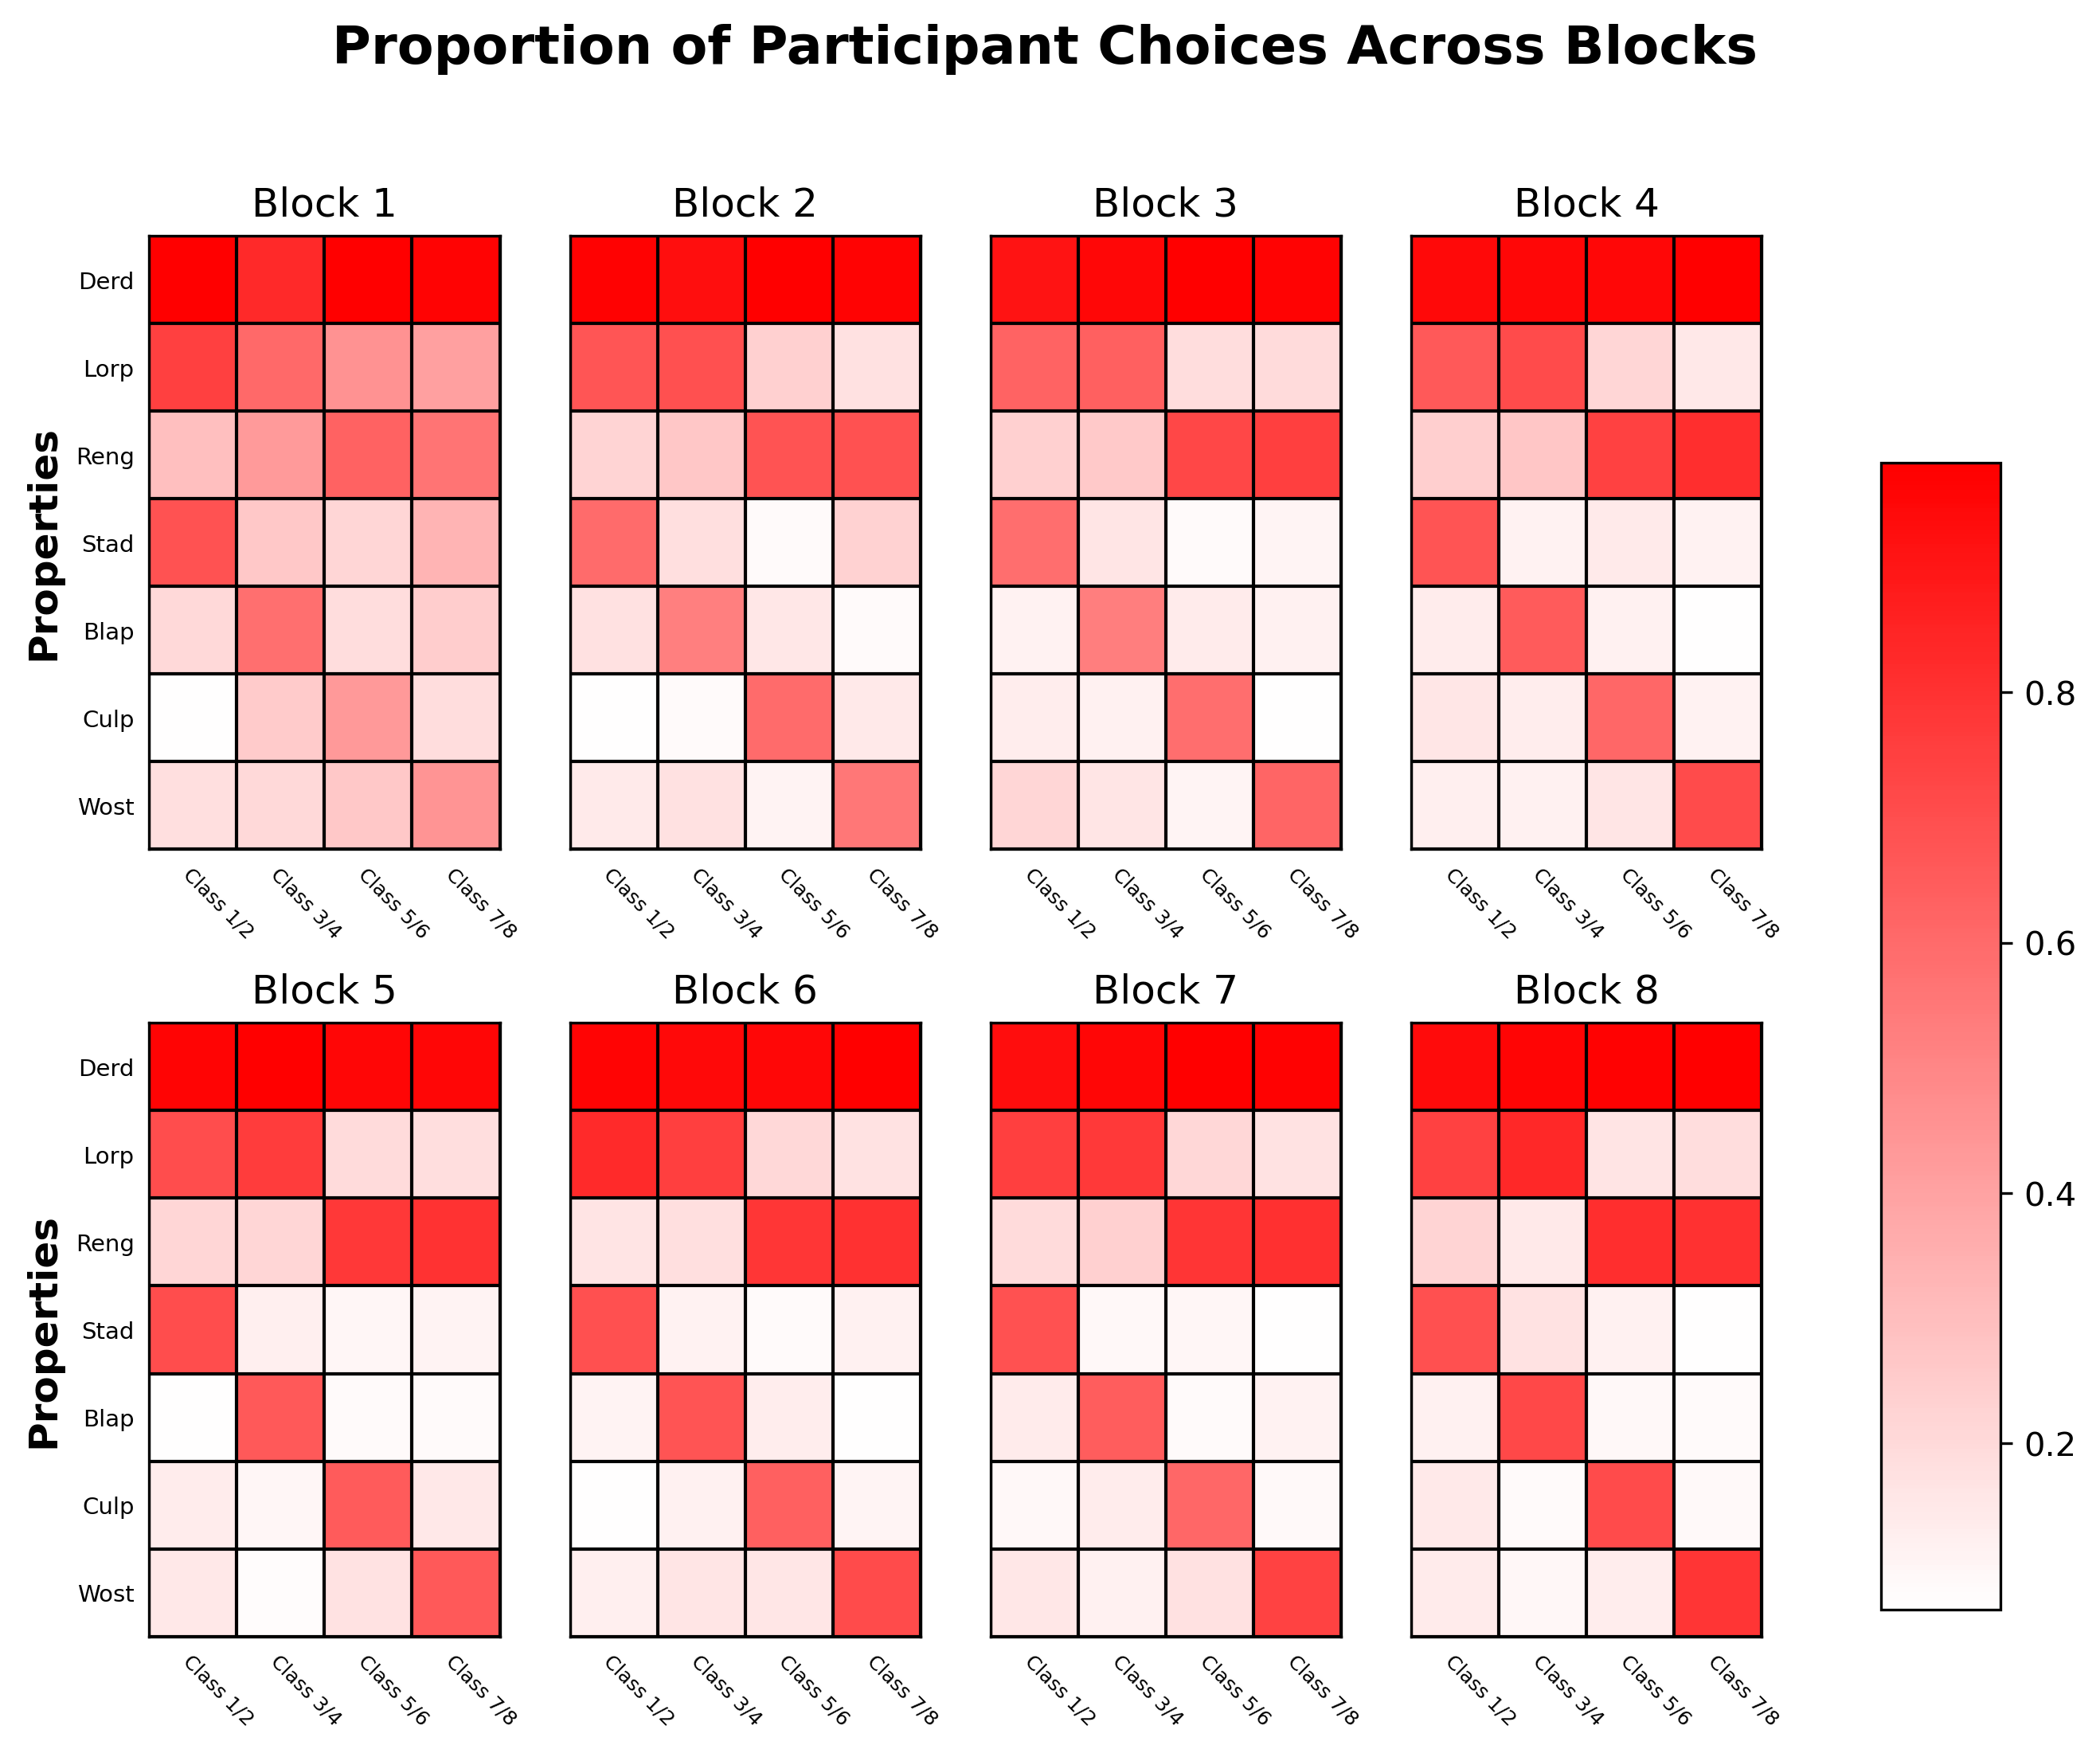

In [224]:
# custom function for the cmap
from matplotlib.pyplot import ylabel


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


def plot_inout_matrix(in_out_matrix, fig_name, fig_title, unit_str, increment):
    # Define figure
    fig, axes = plt.subplots(2, 4, figsize=(10, 8), dpi=300, facecolor='w')
    cmap = plt.get_cmap('bwr')
    new_cmap = truncate_colormap(cmap,0.5, 1)

    # Average per bloc
    for i, ax in enumerate(axes.flatten()):
        im = ax.matshow(in_out_matrix[:,:,i * increment], cmap=new_cmap)

    # remove the ticks and make tick labels
    y_tick_labels = ['Derd','Lorp','Reng','Stad', 'Blap', 'Culp', 'Wost']
    x_tick_labels = ['Class 1/2', 'Class 3/4', 'Class 5/6', 'Class 7/8']

    for i, ax in enumerate(axes.flatten()):
        
        ax.set_title(unit_str + " " + str(i* increment+1))

        # make grid
        ax.set_xticks(np.arange(-.5, len(x_tick_labels)), minor=True)
        ax.set_yticks(np.arange(-.5, len(y_tick_labels)), minor=True)
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

        # remove ticks
        ax.tick_params(which='both', left=False, right=False, top=False, bottom=False, pad=1)

        ax.set_xticks(range(len(x_tick_labels)))
        ax.set_xticklabels(x_tick_labels, rotation= -45, fontsize=6, ha="left", rotation_mode="anchor")

        if i % 4 == 0:
            ax.set_ylabel("Properties",fontweight='bold', fontsize = 12)
            ax.set_yticks(range(len(y_tick_labels)))
            ax.set_yticklabels(y_tick_labels, fontsize=7)
            ax.tick_params(labeltop=False, labelbottom = True)

        else:
            ax.tick_params(labelleft=False, labeltop=False, labelbottom = True)


    # Aesthetics
    # ax.set_ylim(0.3, 1.05)
    # ax.set_xlabel('Block #')
    # ax.set_ylabel('Accuracy')

    # add a supertitle
    fig.suptitle(fig_title, fontweight='bold', fontsize = 16)
    
    # add a colourbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.6])
    fig.colorbar(im, cax=cbar_ax)

    # plt.tight_layout()
    
    fig.savefig(fig_name)

# print(os.getcwd())
plot_inout_matrix(in_out_matrix, 
                  'figure/in_out_matrix.png', 
                  "Proportion of Participant Choices Across Blocks",
                  "Block",
                  1
                )

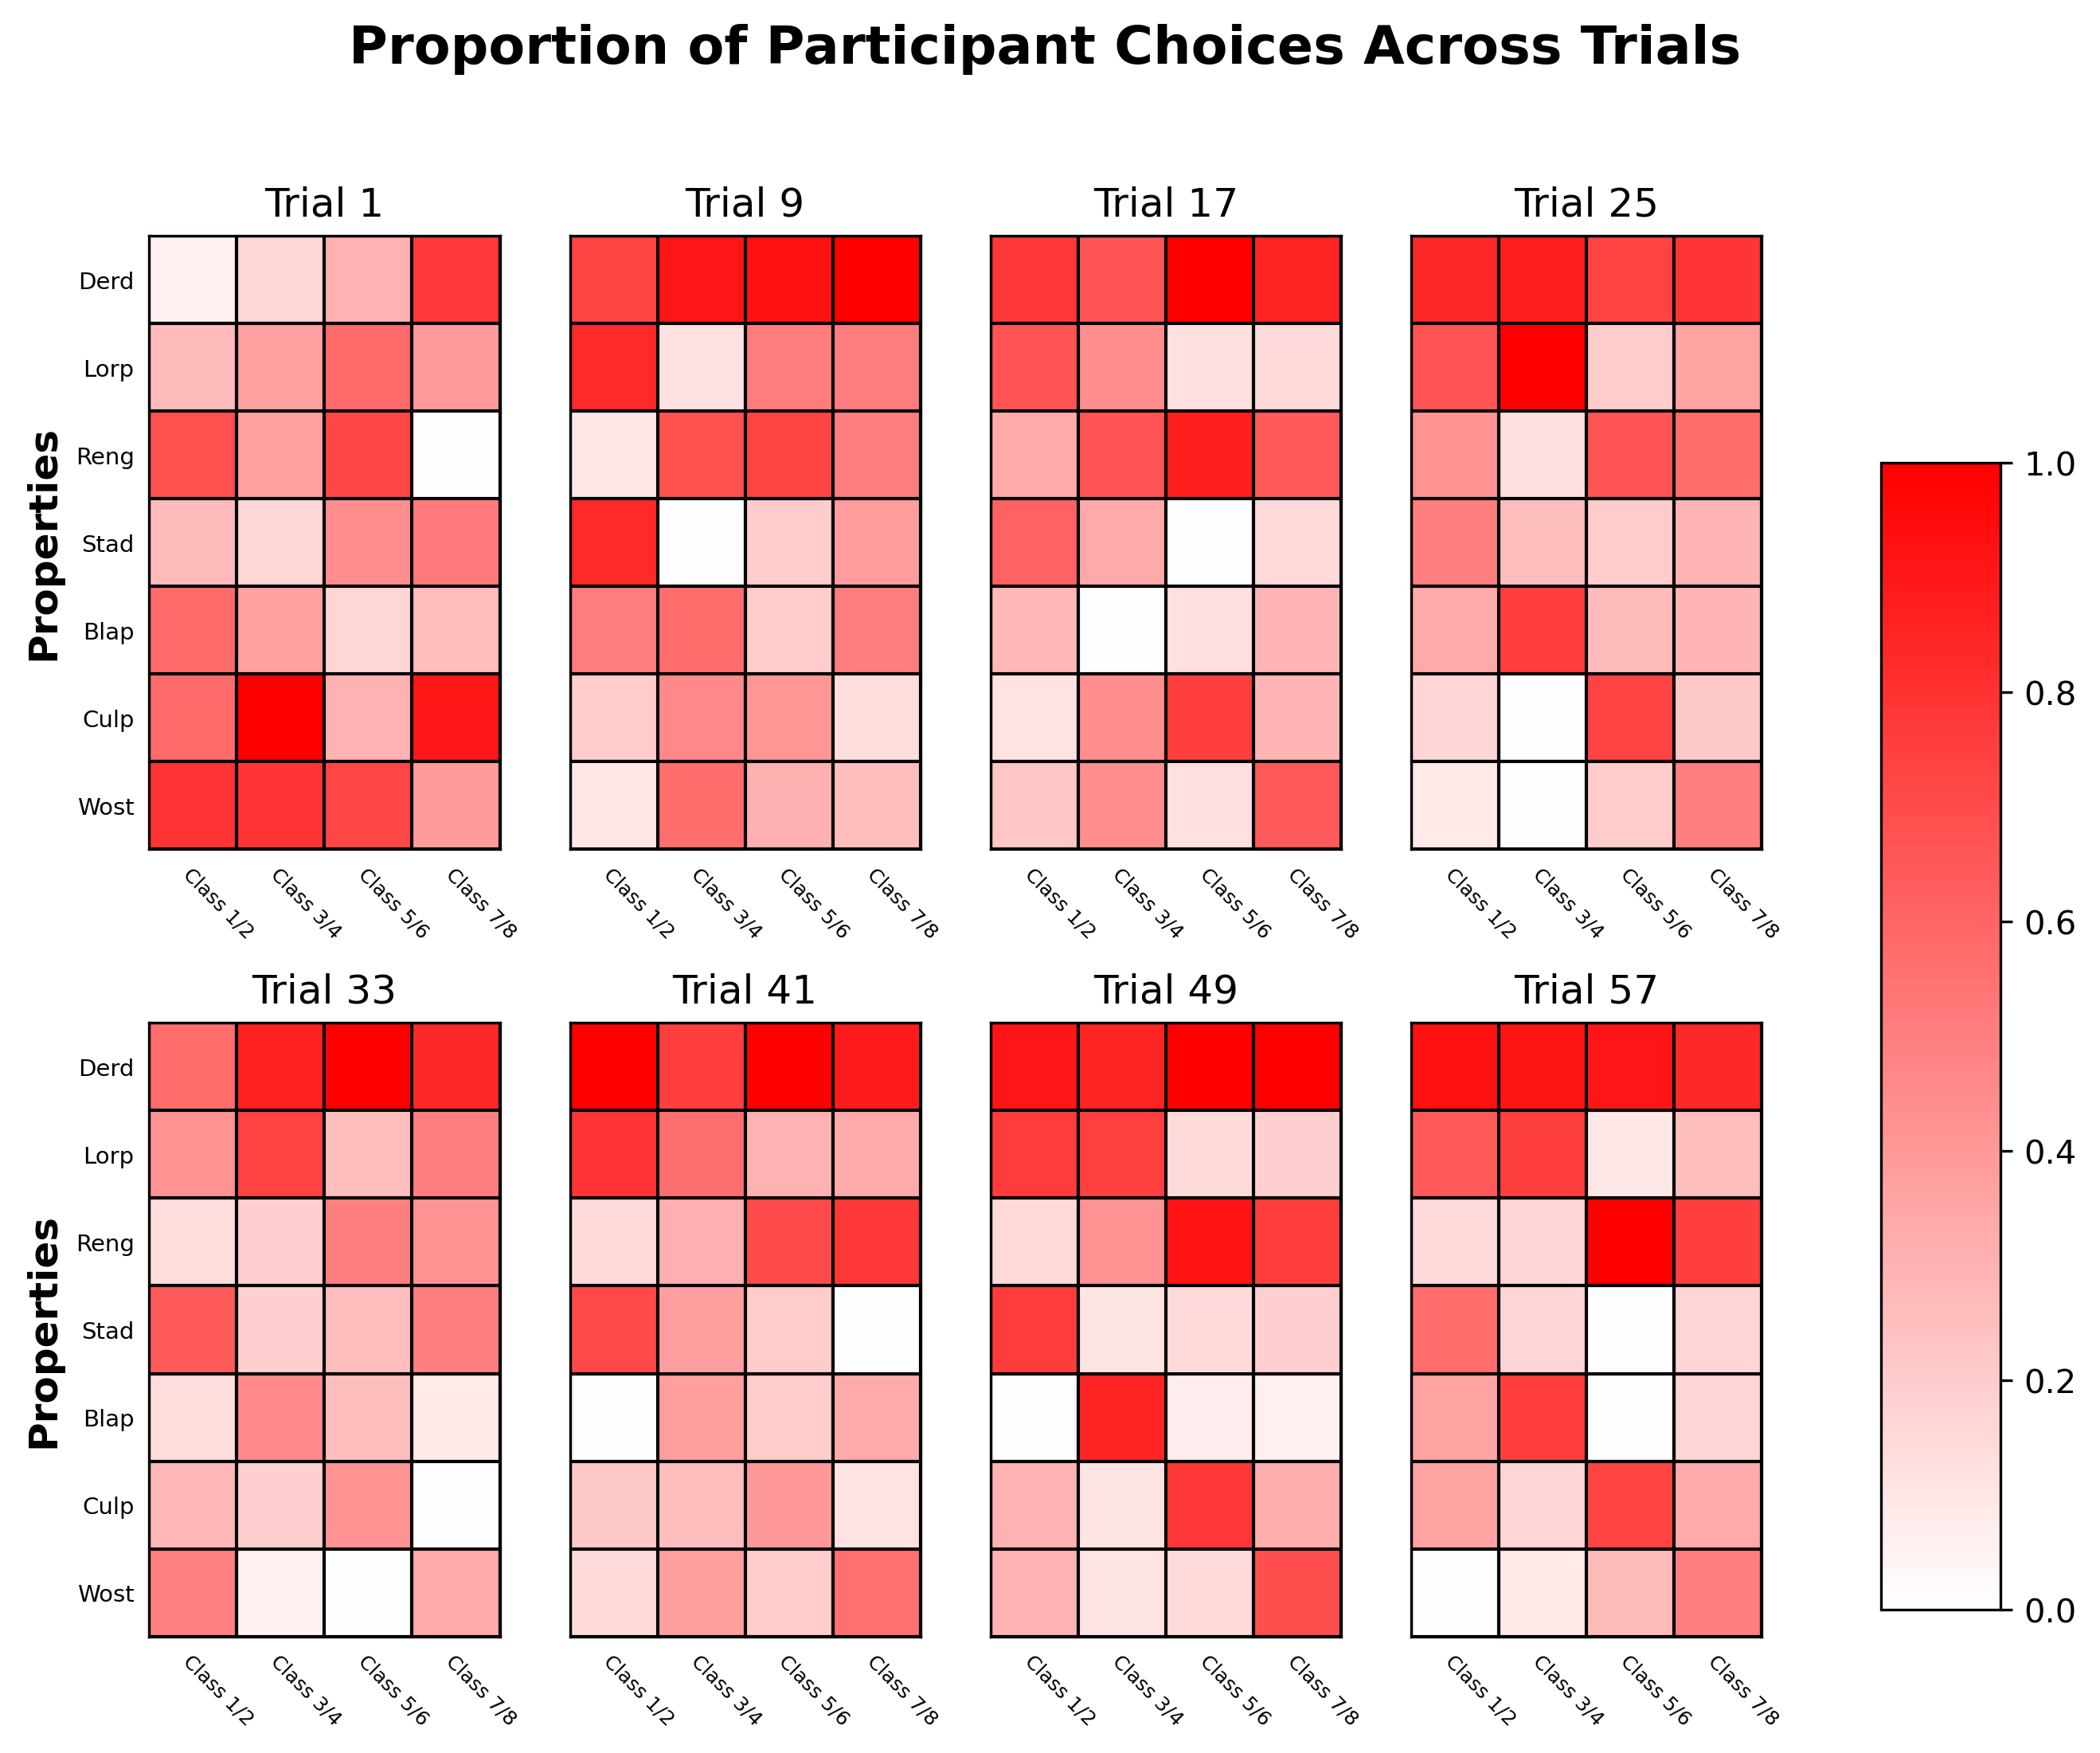

In [227]:
plot_inout_matrix(in_out_matrix_trialwise, 
                'figure/in_out_matrix_first_trials.png', "Proportion of Participant Choices Across Trials",
                "Trial", 8)